# From  [Managing Smile Risk](http://web.math.ku.dk/~rolf/SABR.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import _LIB_Ito_Diffusion as Ito
from _LIB_Vol_Models import *
plt.style.use('dark_background')

In [2]:
T = 1
SCHEME_STEPS = int(1e4)
LEGEND_SIZE = 32
FONT_SIZE = 32
ONE_BP = 1e-4
ONE_PCT = 1e-2
N_STRIKES = 500

## Sample paths

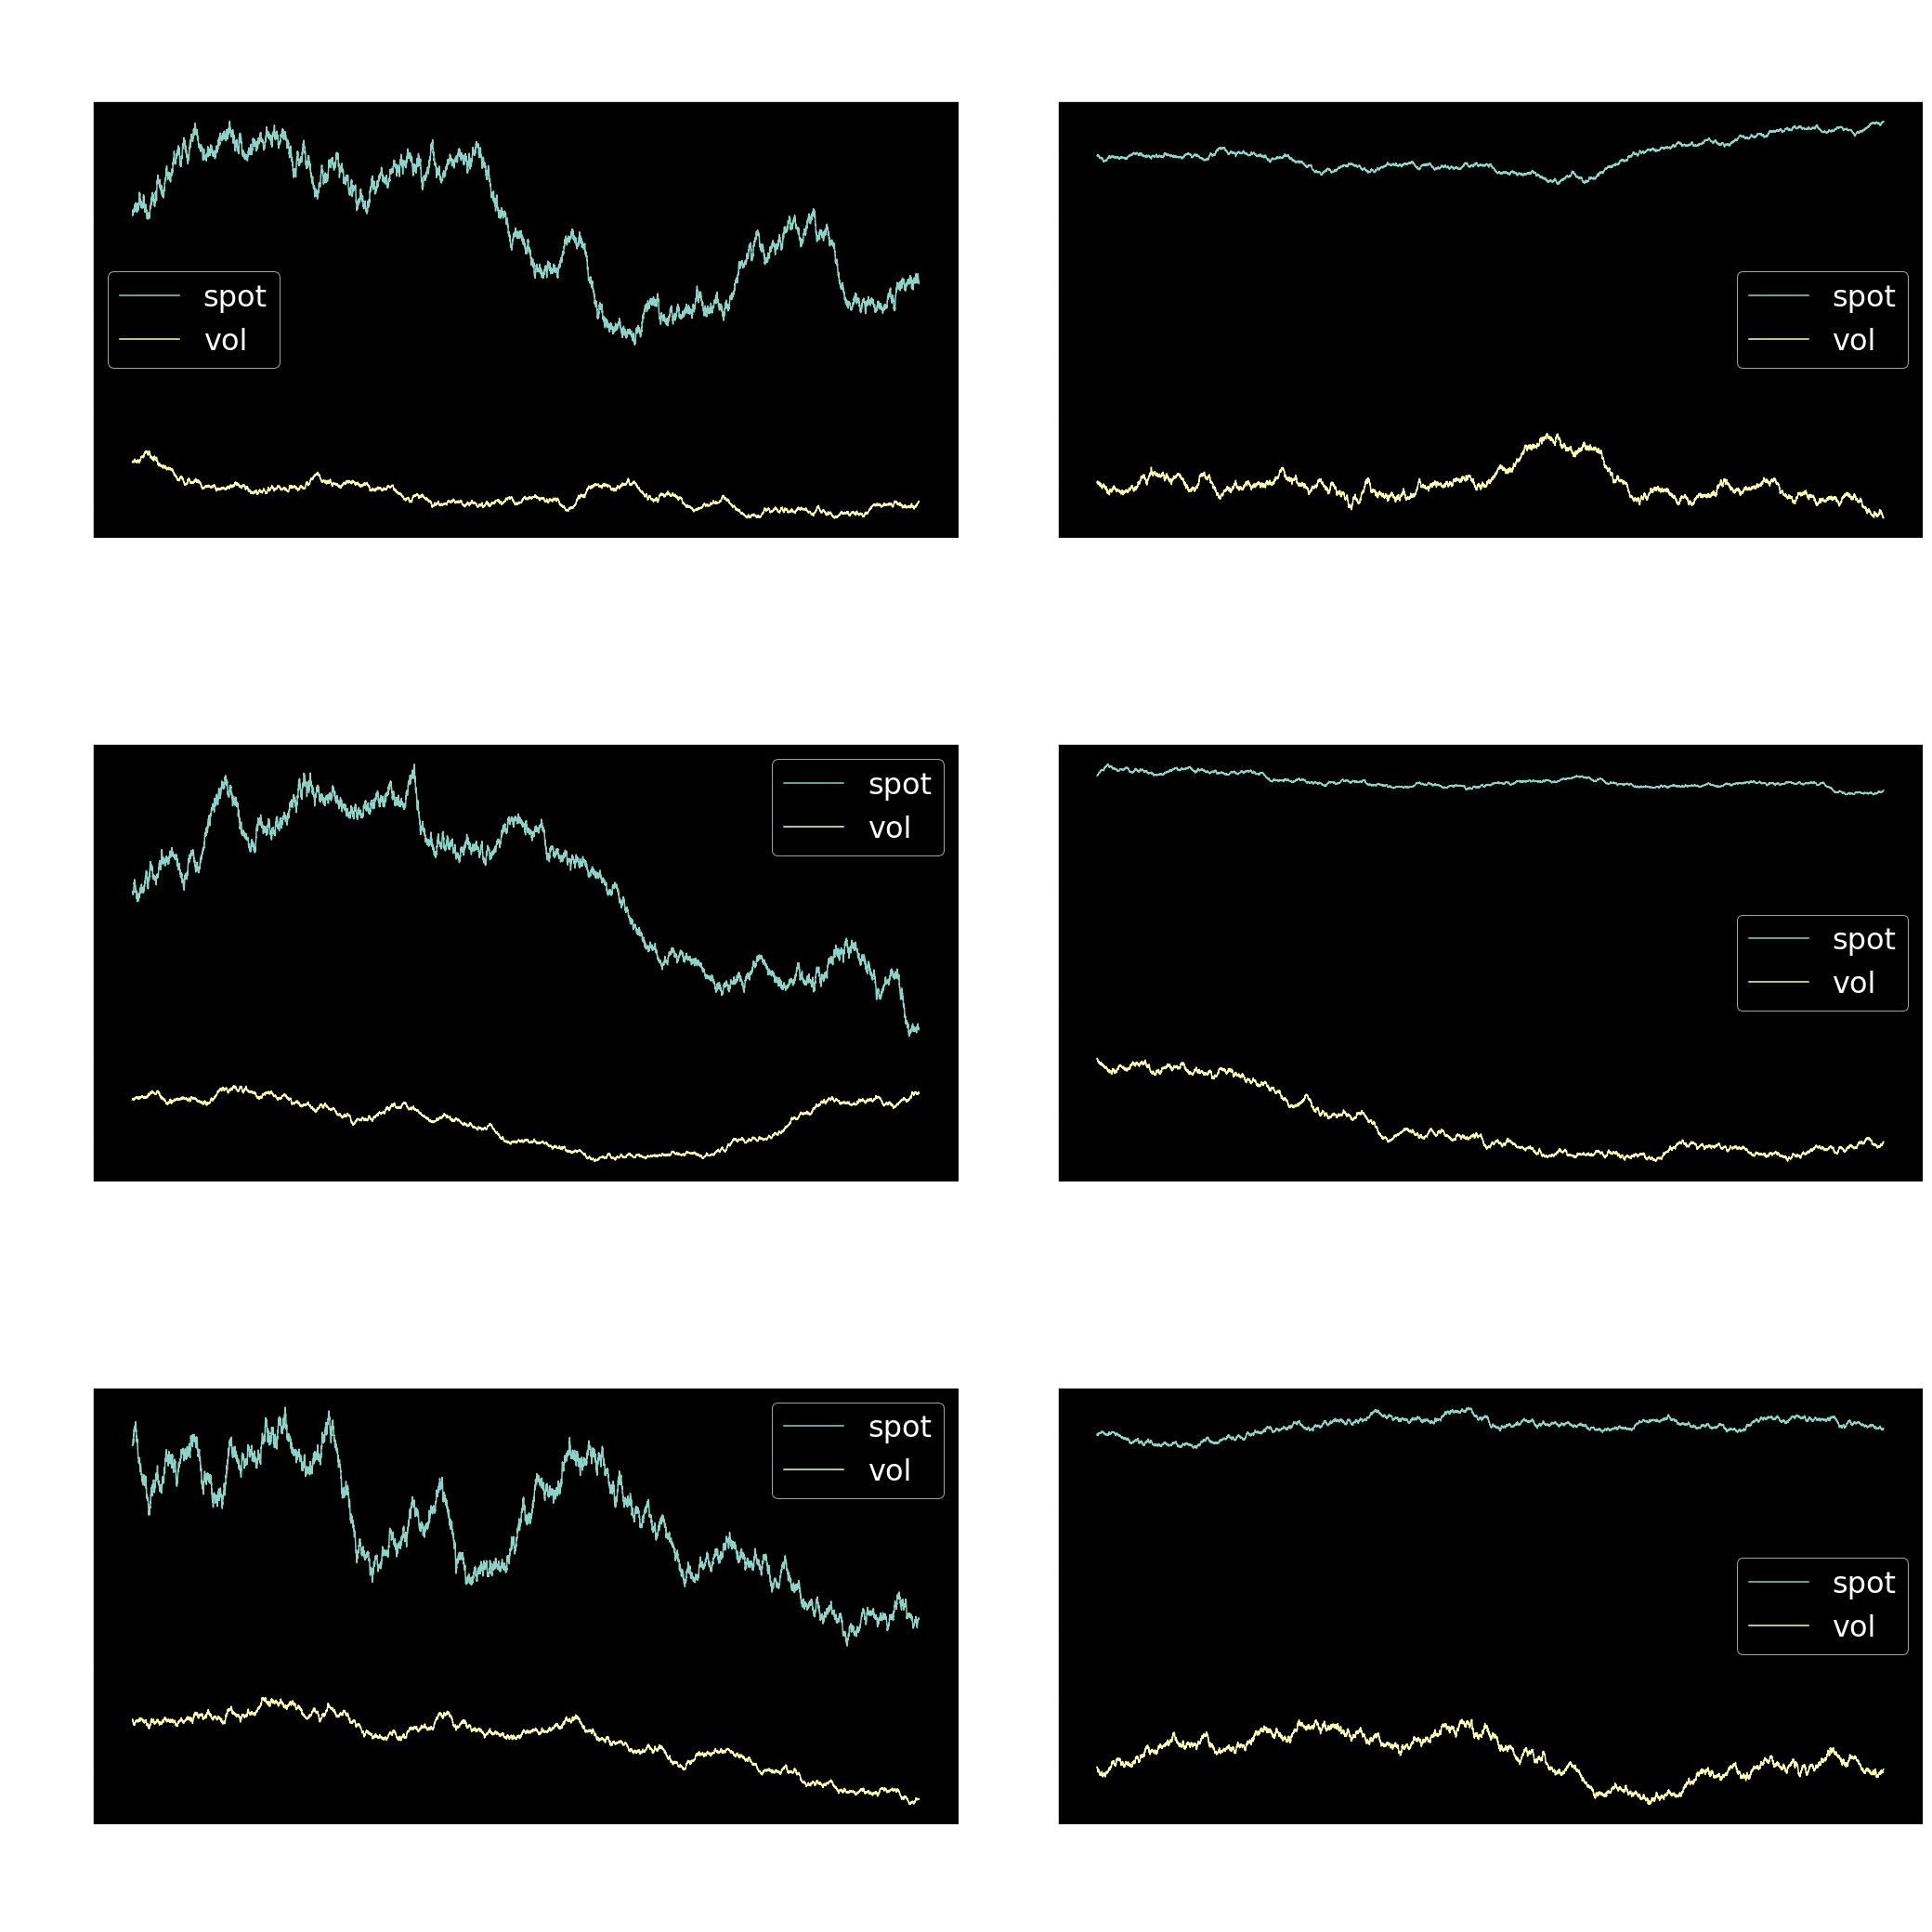

In [3]:
fig, axes = plt.subplots(figsize=(29, 29), nrows=3, ncols=2)

x0 = [1, 0.5]

params = [
    [1.0, -0.5],
    [1.0, 0.0],
    [1.0, 0.5],
    [10.0, -0.5],
    [10.0, 0.0],
    [10.0, 0.5],
]

X = Ito.SABR_tanh(x0=x0, T=T, scheme_steps=SCHEME_STEPS, keys=['spot', 'vol'])

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        vov = 0.2
        l = params[i+3*j][0]
        rho = params[i+3*j][1]
        
        X.l = l
        X.vov = vov
        X.rho = rho
        
        df = X.simulate()
        df.plot(kind='line', ax=ax)

        ax.set_xlabel('time\n', fontsize=FONT_SIZE)
        ax.set_ylabel('spot', fontsize=FONT_SIZE)
        ax.legend(prop={'size': LEGEND_SIZE})
        ax.tick_params(labelsize=FONT_SIZE)
        ax.set_title(r'l={:.2f}'.format(l)+'\n'\
                     r'vov={:.0%}'.format(vov)+'\n'\
                     r'$\rho$={:.0%}'.format(rho),\
                     fontsize=FONT_SIZE)

plt.tight_layout()
plt.show()

## Numerical experiments

In [4]:
f = 2*ONE_PCT
l = 0.1
vov = 40*ONE_PCT
rho = -40*ONE_PCT
moneyness_lo = -8
moneyness_hi = 6
sigma_0 = 50*ONE_BP

In [5]:
Model_LN = SABR_tanh_LN(l=l, vov=vov, rho=rho, f=f, sigma_0=sigma_0,\
                         n_strikes=N_STRIKES,\
                         moneyness_lo=moneyness_lo, moneyness_hi=moneyness_hi)
Model_N = SABR_tanh_N(l=l, vov=vov, rho=rho, f=f, sigma_0=sigma_0,\
                       n_strikes=N_STRIKES,\
                       moneyness_lo=moneyness_lo, moneyness_hi=moneyness_hi)

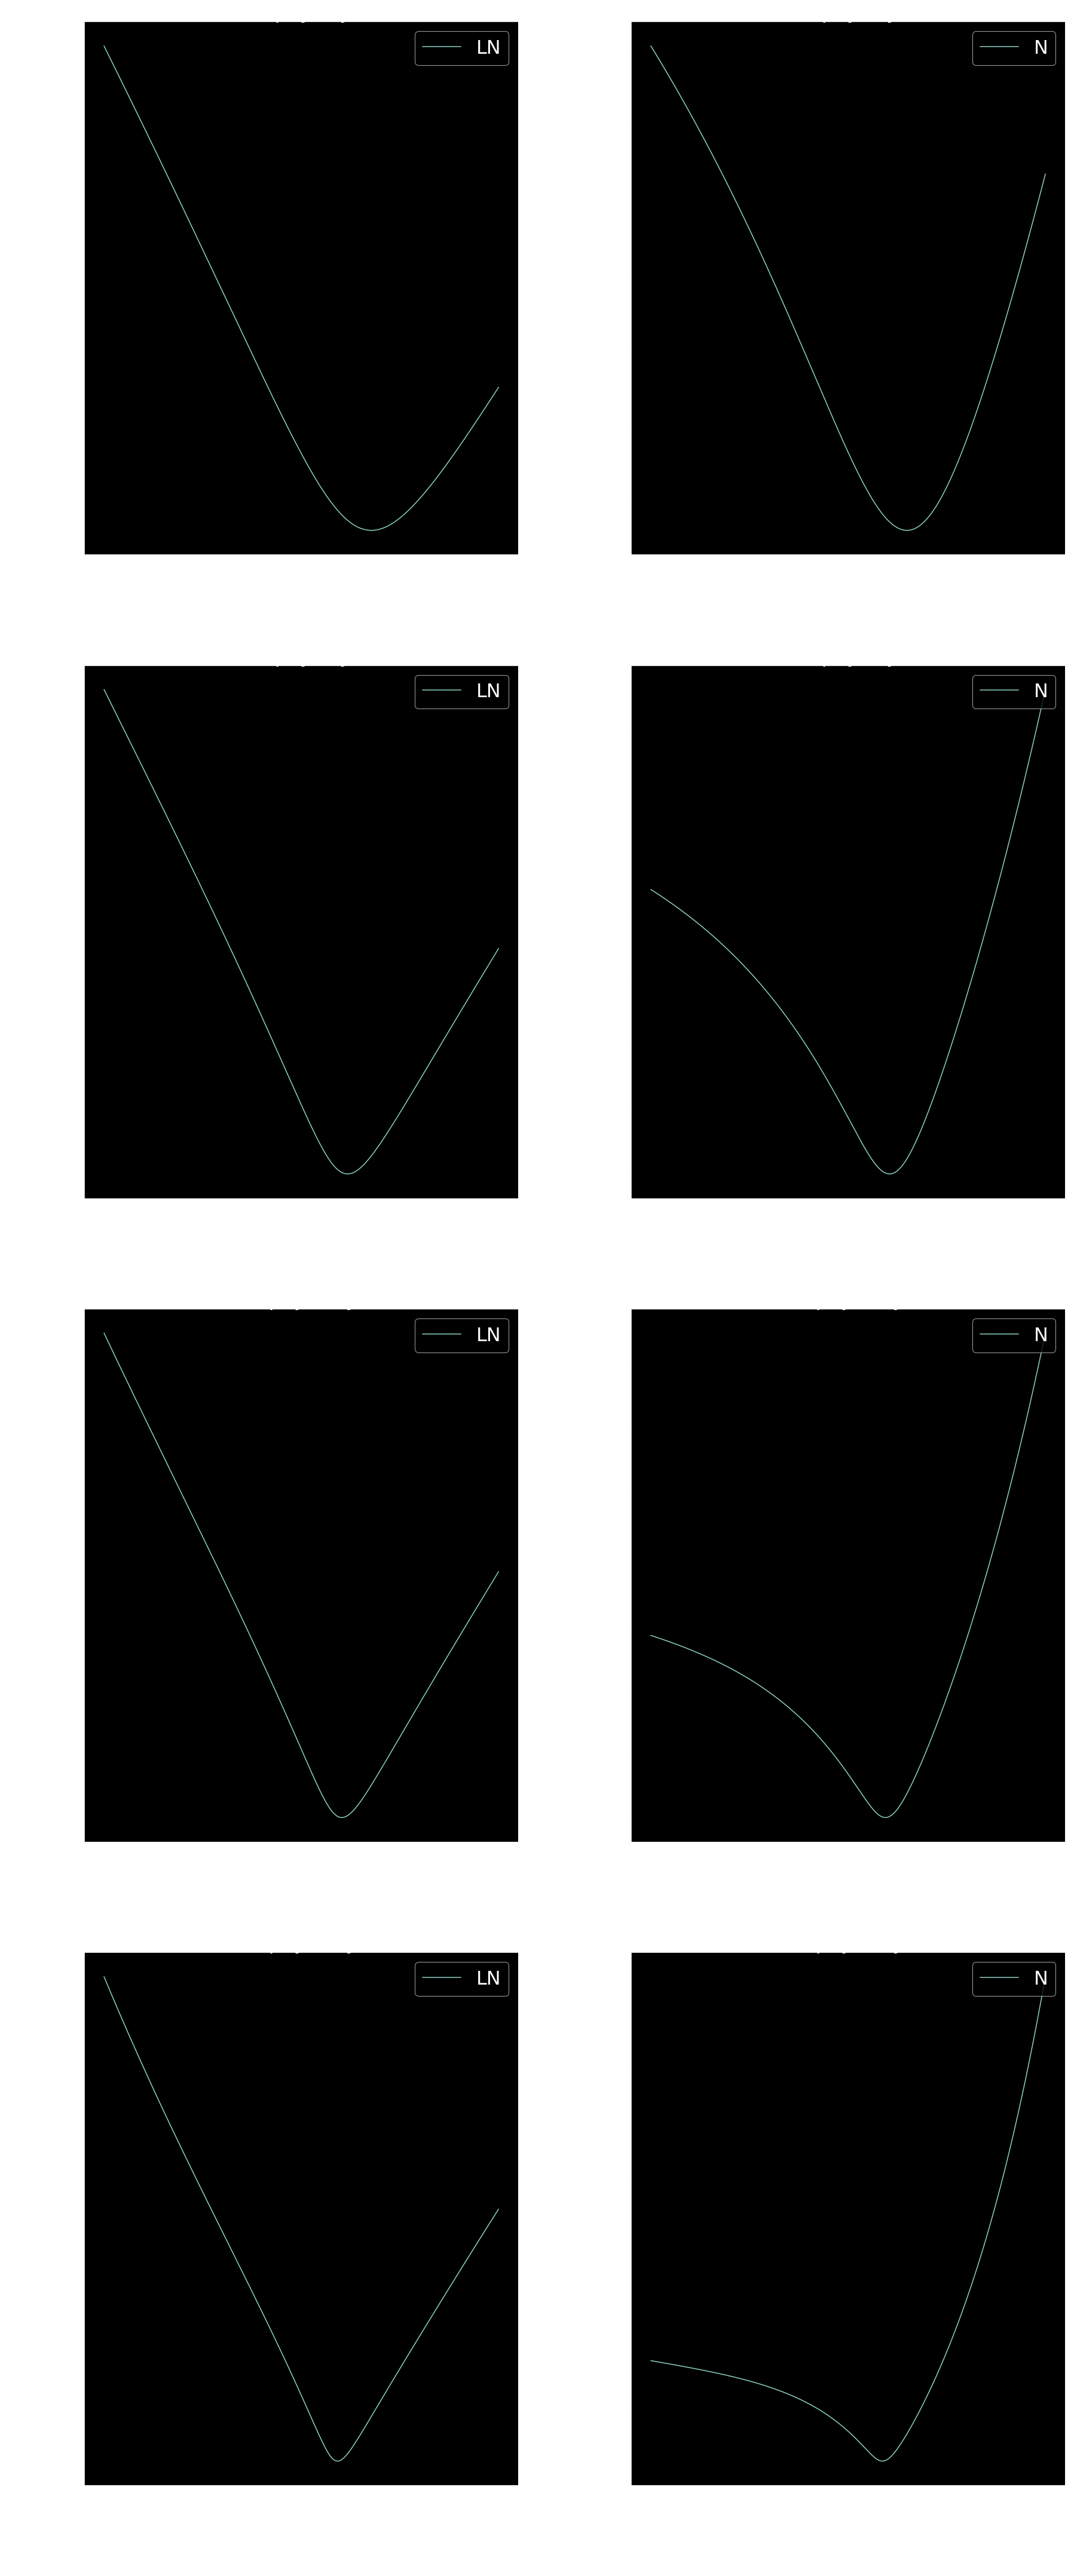

In [6]:
xlabel = 'logmoneyness\n\n'
ylabel = 'implied vol'
labels = ['LN', 'N']

T_expiries = [1, 5, 10, 20]

fig, axes = plt.subplots(figsize=(25, 60), nrows=4, ncols=2)

for i, ax_row in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_LN.T_expiry = T_expiry
    Model_N.T_expiry = T_expiry
    x_grid = Model_LN.logmoneyness_grid

    models = [Model_LN, Model_N]
    for j, ax in enumerate(ax_row):
        model = models[j]
        label = labels[j]
        smile = model.smile.values()

        ax.plot(x_grid, smile, label=label)

        ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
        ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
        ax.legend(loc='upper right', prop={'size': LEGEND_SIZE})
        ax.tick_params(labelsize=FONT_SIZE)
        ax.set_title('expiry={}y'.format(T_expiry), fontsize=FONT_SIZE)

plt.tight_layout()
plt.show()

## Implied probability density

As with Hagan's original formula, issues arise on the left wing for long expiries, although in the sense that higher density on the tail is unrealistic. However the implied density seem to remain positive, so overall the expansion seems more stable.

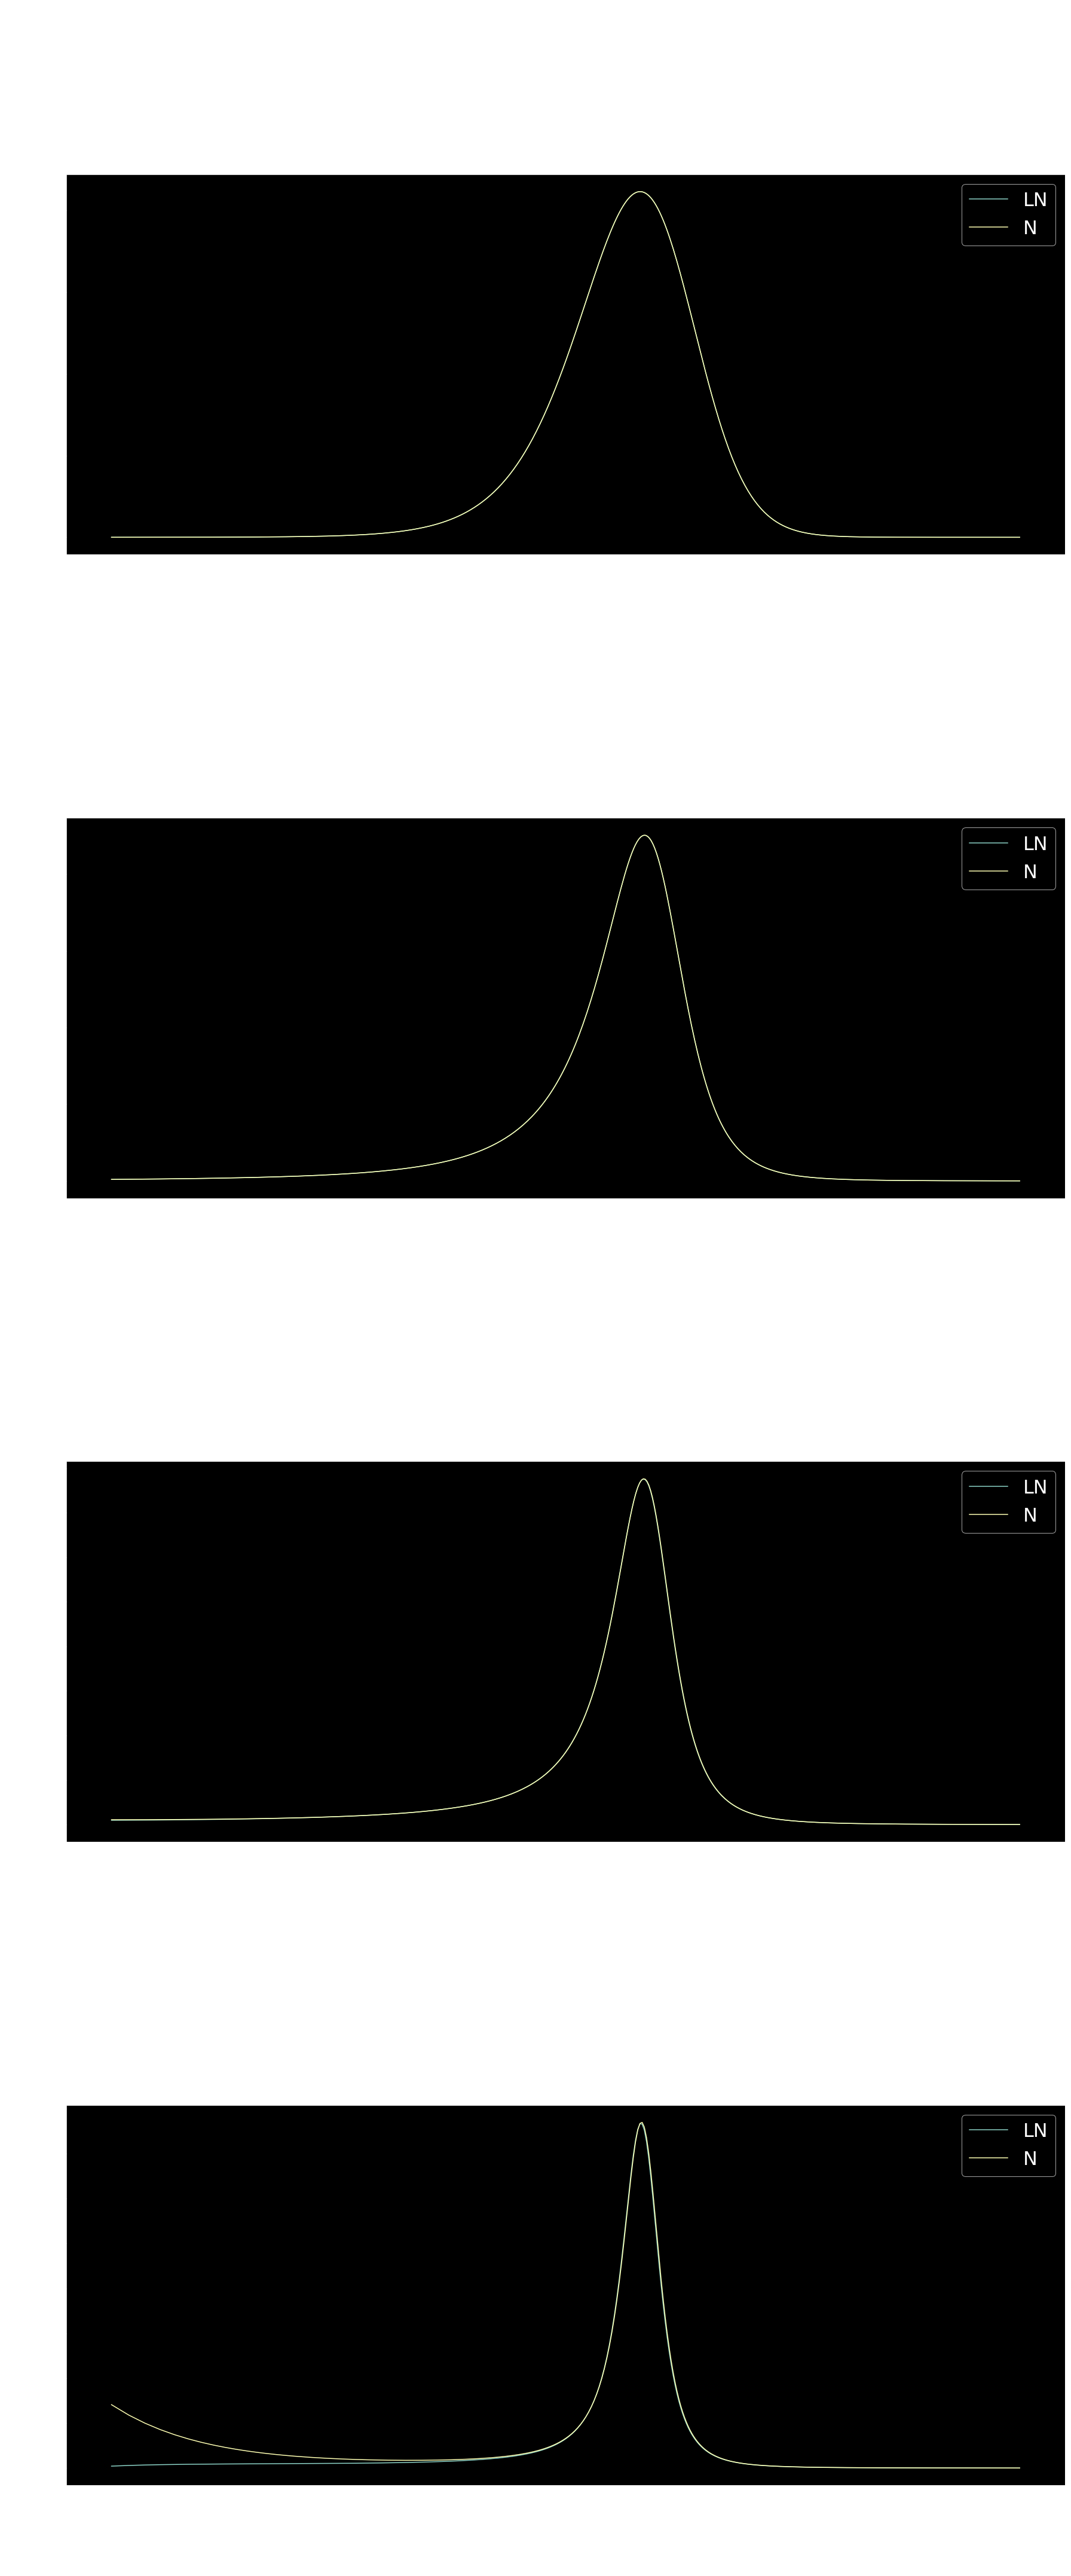

In [7]:
xlabel = 'logmoneyness\n\n'
ylabel = 'pdf'

T_expiries = [1, 5, 10, 20]

fig, axes = plt.subplots(figsize=(25, 60), nrows=4, ncols=1)

for i, ax in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_LN.T_expiry = T_expiry
    Model_N.T_expiry = T_expiry
    
    x_grid = Model_LN.logmoneyness_grid
    
    pdf_LN = Model_LN.pdf_curve.values()
    pdf_N = Model_N.pdf_curve.values()

    ax.plot(x_grid, pdf_LN, label='LN')
    ax.plot(x_grid, pdf_N, label='N')

    ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
    ax.legend(loc='upper right', prop={'size': LEGEND_SIZE})
    ax.tick_params(labelsize=FONT_SIZE)

    ax.set_title(r'$f$={:.2%}'.format(Model_LN.f)+'\n' +\
                 r'l={:.2}'.format(Model_LN.l)+'\n' +\
                 r'vov={:.0%}'.format(Model_LN.vov)+'\n' +\
                 r'$\rho$={:.0%}'.format(Model_LN.rho)+'\n'+\
                 r'ATM(LN)={:.2%}, ATM(N)={:.2f}bps'.format(Model_LN.ATM, Model_N.ATM/ONE_BP)+'\n'+\
                 r'$\sigma_0$={:.2%}'.format(Model_LN.sigma_0)+'\n'+\
                 r'expiry={}y'.format(T_expiry)+'\n',\
                 fontsize=FONT_SIZE)

plt.tight_layout()
plt.show()

## Backbone i.e ATM vol move implied by forward move

Given $tanh(x)$ is equivalent to $x$ when $x$ is small and close to $1$ when $x$ is large, SABR_tanh can be seen as a mixture of SABR lognormal and normal controlled by the scale parameter $l$.

Therefore, in lognormal space :
* $l$ large : similar to lognormal SABR, flat backbone, the ATM remains the same when the forward moves (sticky by delta),
* $l$ small : similar to normal SABR, decreasing backbone, the ATM is higher for lower forward.

The opposite rules apply in normal space :
* $l$ large : similar to lognormal SABR, increasing backbone, the ATM is lower for lower forward,
* $l$ small : similar to normal SABR, flat backbone.

The backbone dynamically moves between those two extreme behaviours depending on $l$ and the current forward.

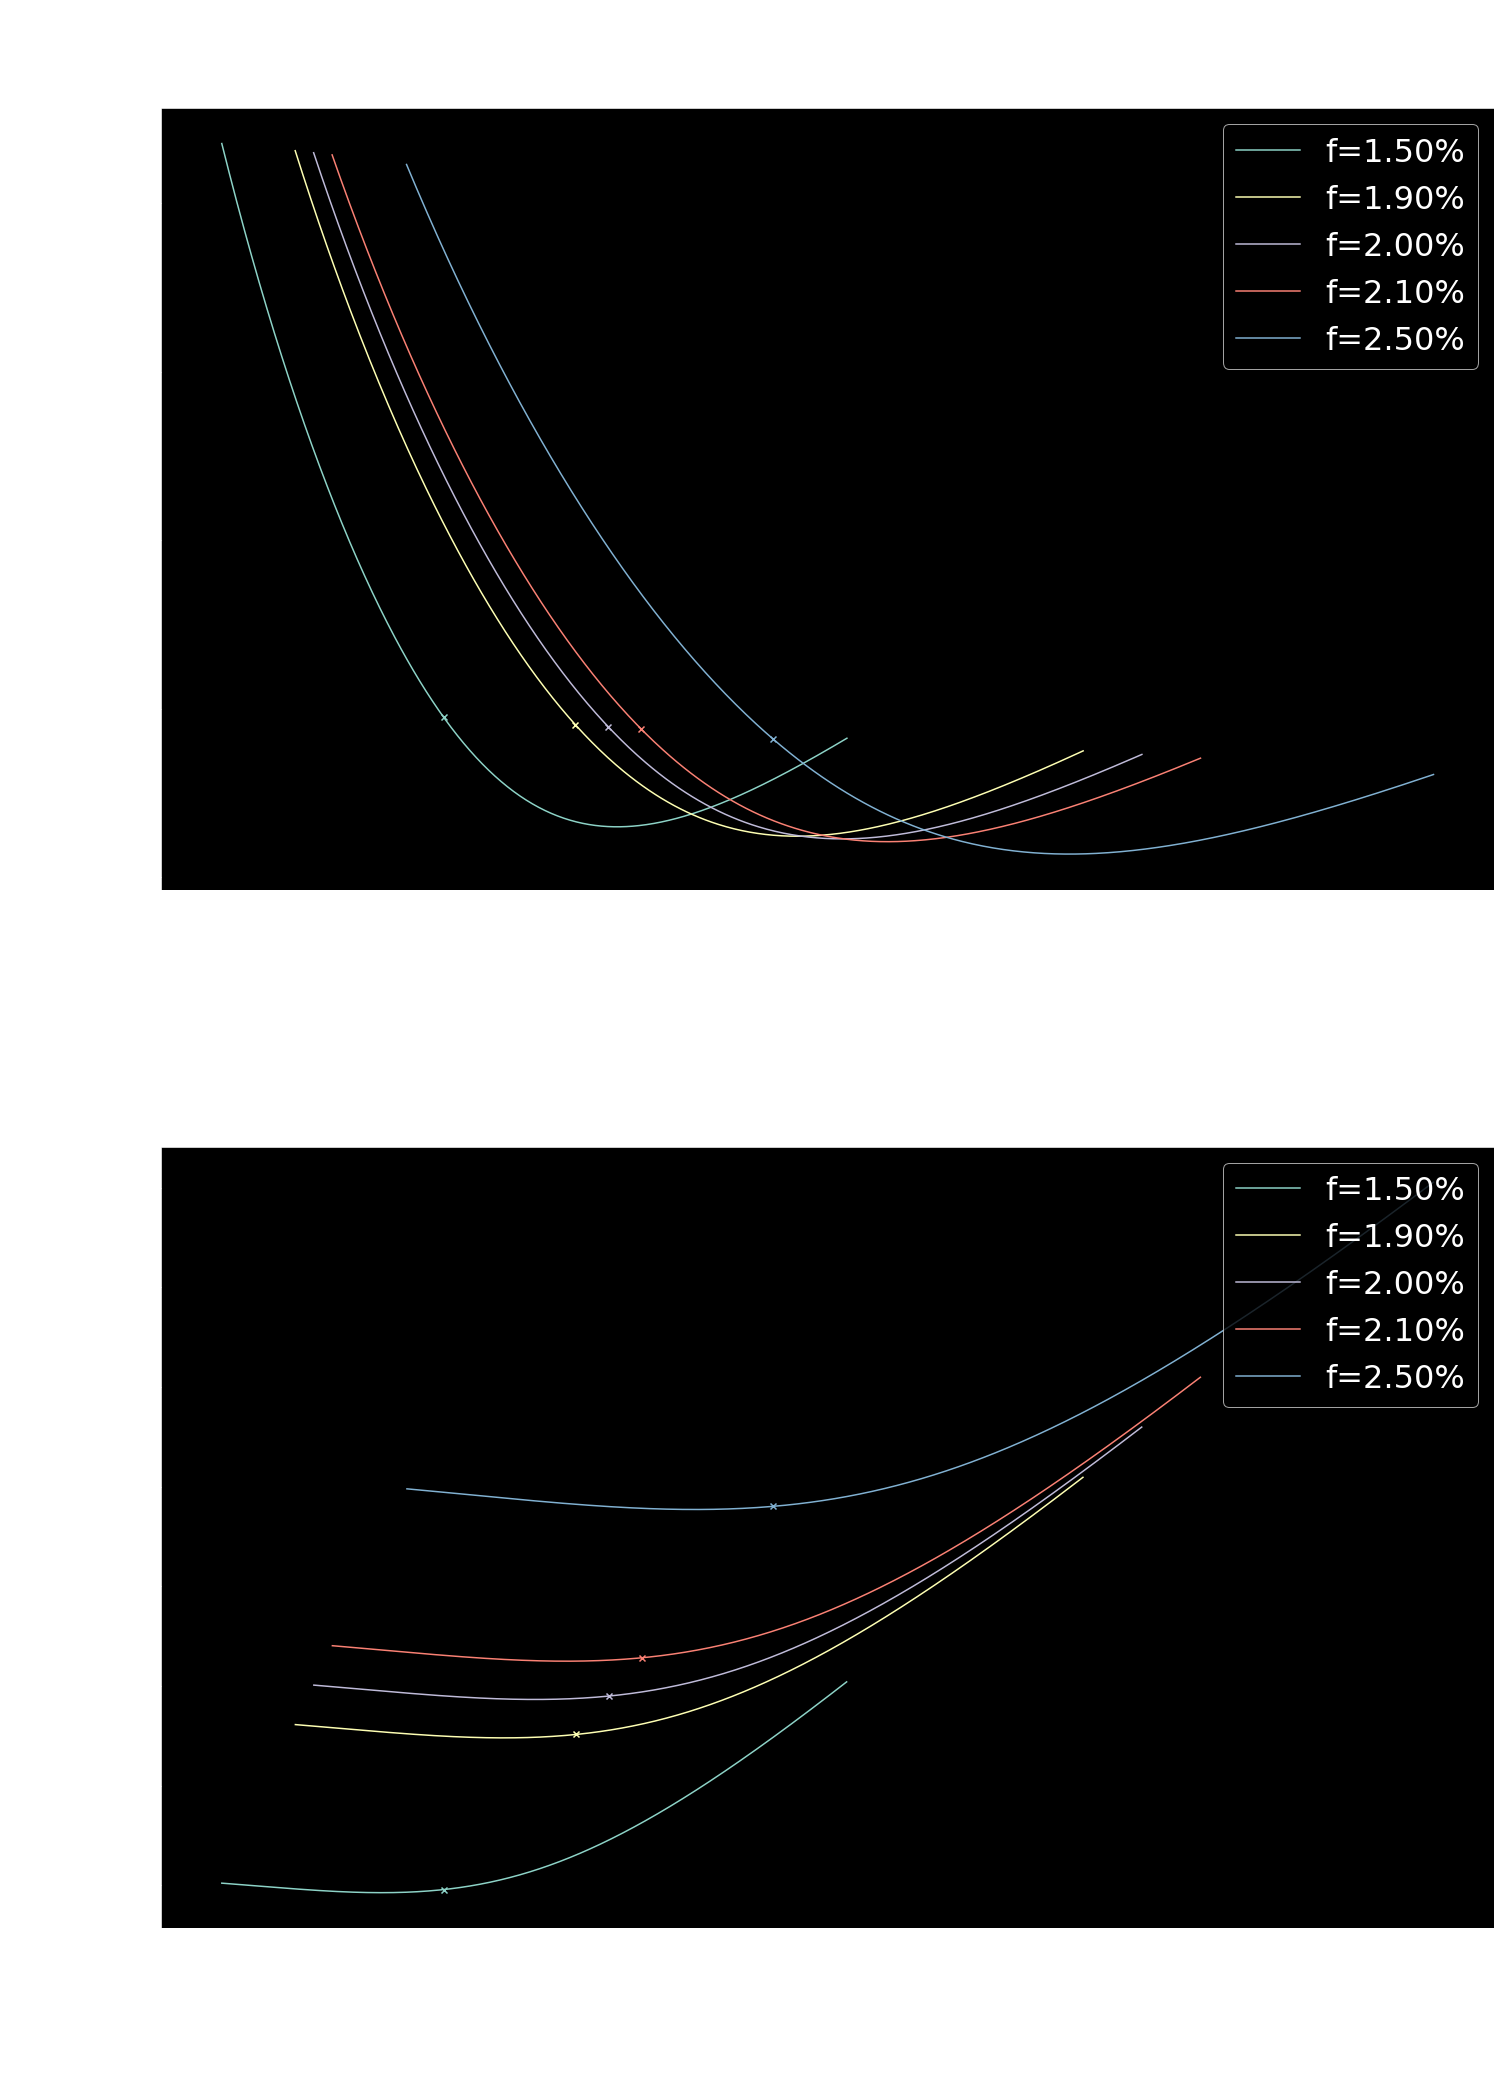

In [8]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 2*ONE_PCT
sigma_0 = 27*ONE_BP

f_shocks = [
    -50*ONE_BP, 
    -10*ONE_BP, 
    0, 
    10*ONE_BP, 
    50*ONE_BP
]

f = 2*ONE_PCT

vov = 40*ONE_PCT
rho = -40*ONE_PCT
sigma_0 = 200*ONE_BP
l = 0.1

Model_LN = SABR_tanh_LN(l=l, vov=vov, rho=rho, f=f, sigma_0=sigma_0,\
                         n_strikes=N_STRIKES, T_expiry=1,\
                         moneyness_lo=-3, moneyness_hi=3)
Model_N = SABR_tanh_N(l=l, vov=vov, rho=rho, f=f, sigma_0=sigma_0,\
                       n_strikes=N_STRIKES, T_expiry=1,\
                       moneyness_lo=-3, moneyness_hi=3)

models = [Model_LN, Model_N]

fig, axes = plt.subplots(figsize=(21, 29), nrows=2, ncols=1)
    
for i, ax in enumerate(axes):
    model = models[i]
    for f_shock in f_shocks:
        model.f = f+f_shock
        smile = model.smile.values()
        label = 'f={:.2%}'.format(f+f_shock)
        ax.plot(model.strike_grid, smile, label=label)
        ax.scatter([model.f], [model.ATM], marker='x')

        ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
        ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
        ax.legend(loc='upper right', prop={'size': LEGEND_SIZE})
        ax.tick_params(labelsize=FONT_SIZE)
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
        ax.set_title('{}\n'.format(model.vol_type)\
                     +'l={:.2f}'.format(l) +'\n',\
                     fontsize=FONT_SIZE)

plt.tight_layout()
plt.show()

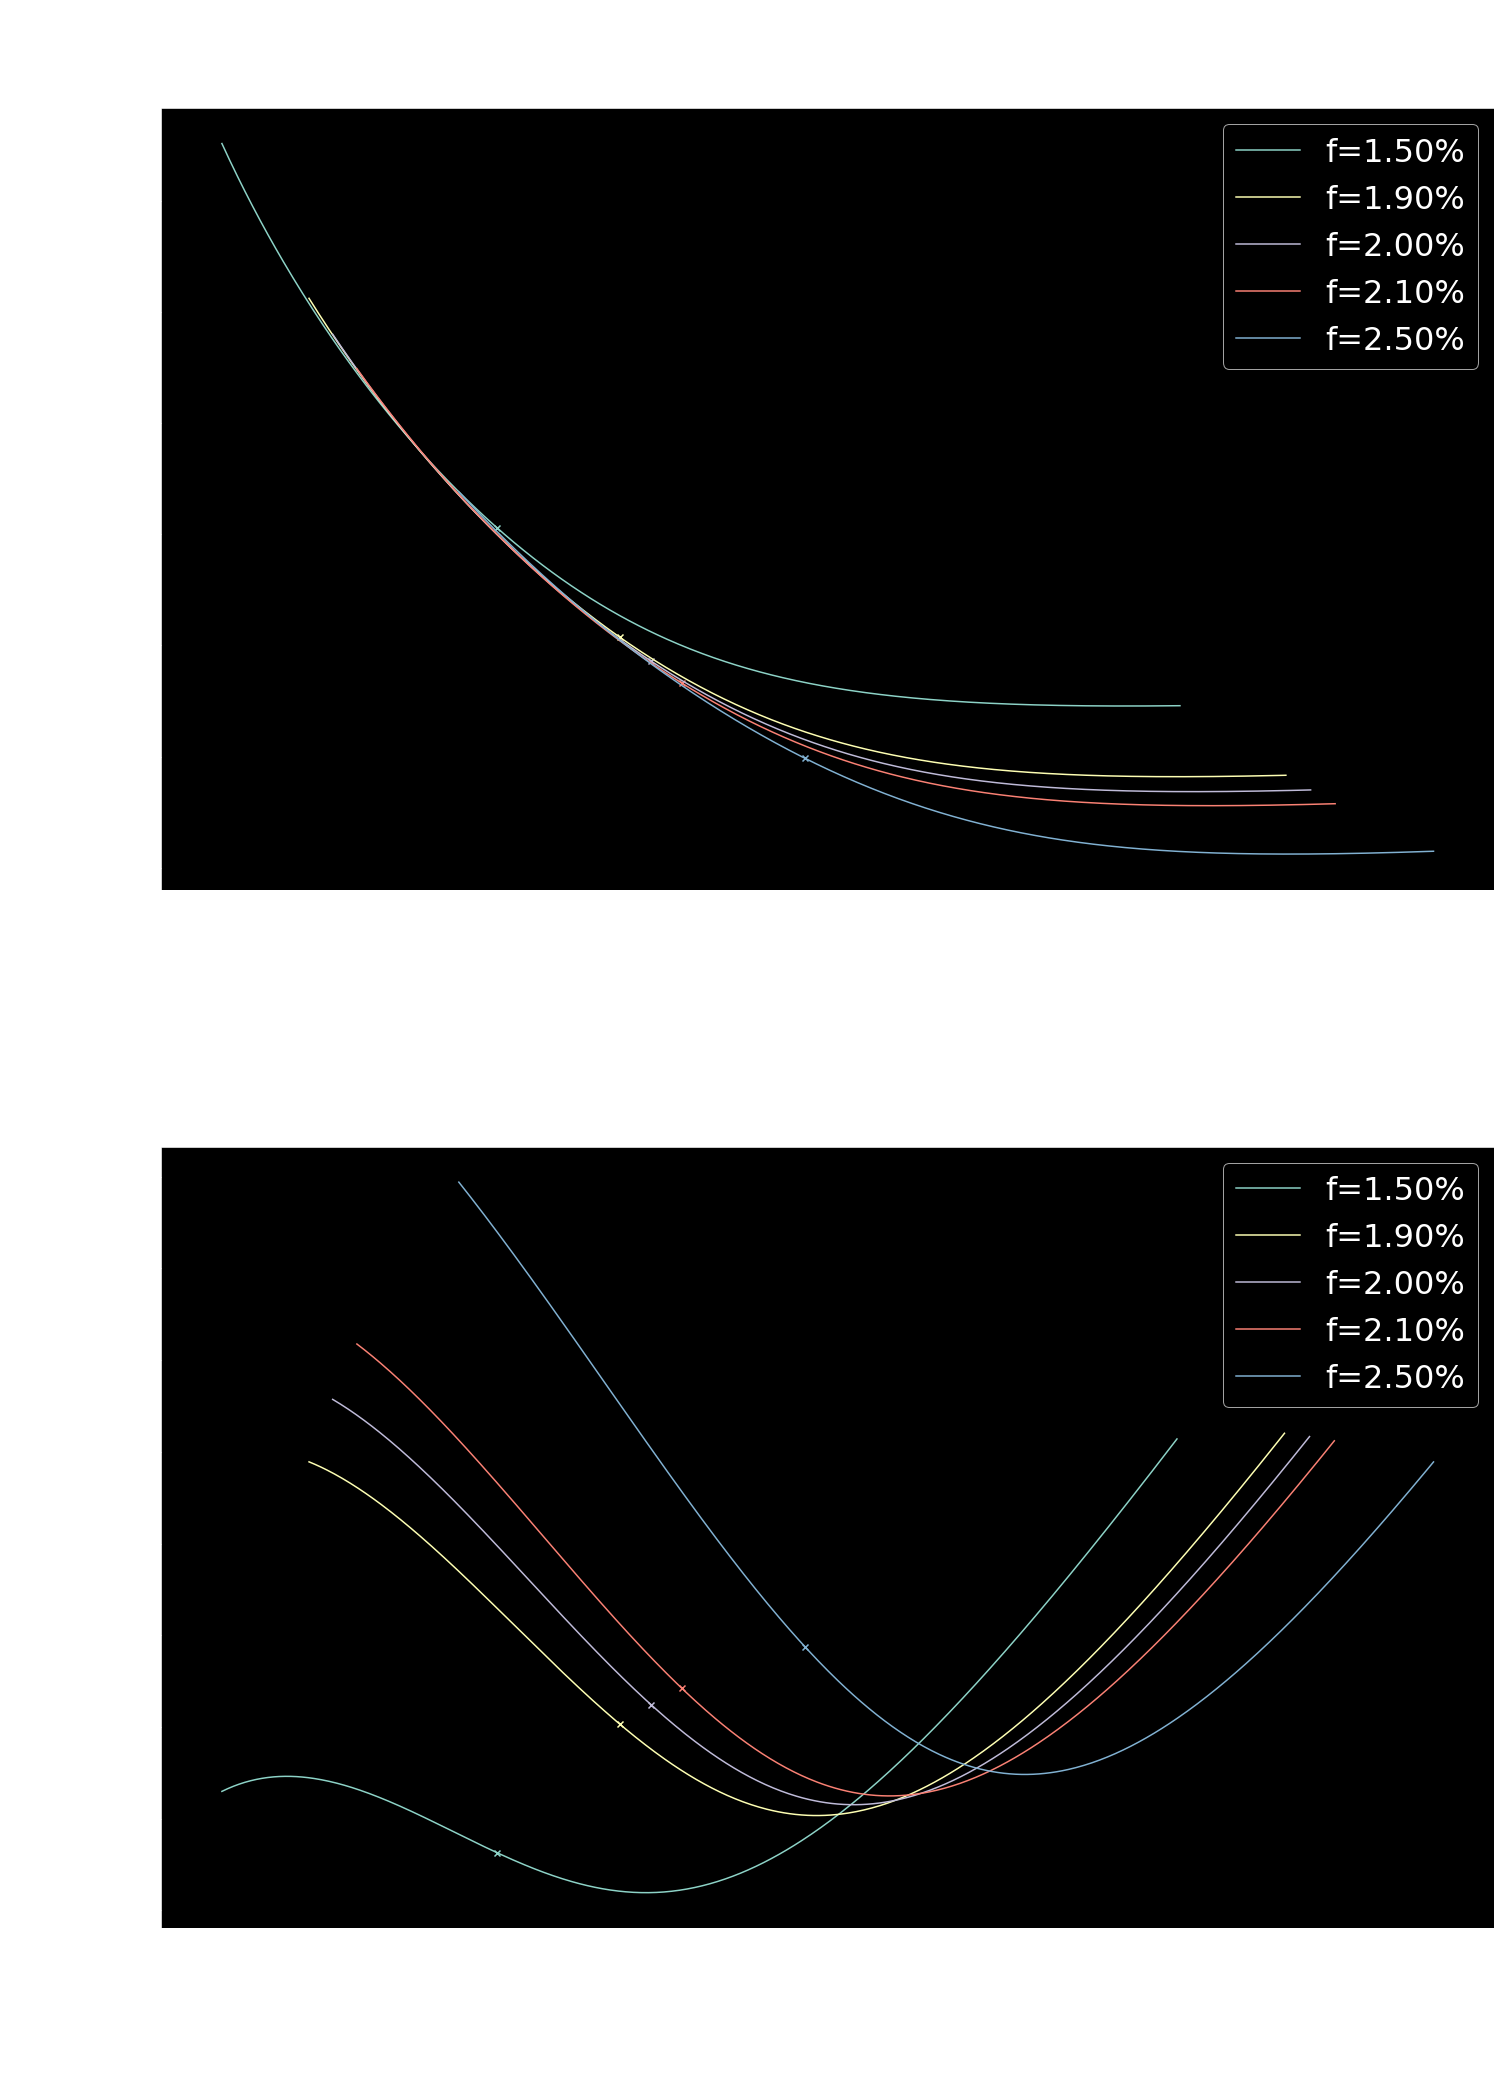

In [9]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 2*ONE_PCT
sigma_0 = 27*ONE_BP

f_shocks = [
    -50*ONE_BP, 
    -10*ONE_BP, 
    0, 
    10*ONE_BP, 
    50*ONE_BP
]

f = 2*ONE_PCT

vov = 40*ONE_PCT
rho = -40*ONE_PCT
sigma_0 = 50*ONE_BP
l = 0.01

Model_LN = SABR_tanh_LN(l=l, vov=vov, rho=rho, f=f, sigma_0=sigma_0,\
                         n_strikes=N_STRIKES, T_expiry=1,\
                         moneyness_lo=-3, moneyness_hi=3)
Model_N = SABR_tanh_N(l=l, vov=vov, rho=rho, f=f, sigma_0=sigma_0,\
                       n_strikes=N_STRIKES, T_expiry=1,\
                       moneyness_lo=-3, moneyness_hi=3)

models = [Model_LN, Model_N]

fig, axes = plt.subplots(figsize=(21, 29), nrows=2, ncols=1)
    
for i, ax in enumerate(axes):
    model = models[i]
    for f_shock in f_shocks:
        model.f = f+f_shock
        smile = model.smile.values()
        label = 'f={:.2%}'.format(f+f_shock)
        ax.plot(model.strike_grid, smile, label=label)
        ax.scatter([model.f], [model.ATM], marker='x')

        ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
        ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
        ax.legend(loc='upper right', prop={'size': LEGEND_SIZE})
        ax.tick_params(labelsize=FONT_SIZE)
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
        ax.set_title('{}\n'.format(model.vol_type)\
                     +'l={:.2f}'.format(l) +'\n',\
                     fontsize=FONT_SIZE)

plt.tight_layout()
plt.show()

## Parameter sensitivities

Vol of vol controls the convexity of the smile, $\rho$ the skew (i.e rotation around the ATM).
Both have little to no effect on the ATM itself.

$\sigma_0$ controls the ATM via parallel shifts of the whole smile.

$l$ also controls the ATM : when $\frac{X_t}{l}$ is small enough, $dX_t \approx \frac{\sigma_t}{l}X_tdW_t$ so $l$ acts in a similar way to $\sigma_0$. However $l$ also impacts the backbone shape, so one should first mark $l$ to control the smile dynamics, and then correct the ATM level using $\sigma_0$.

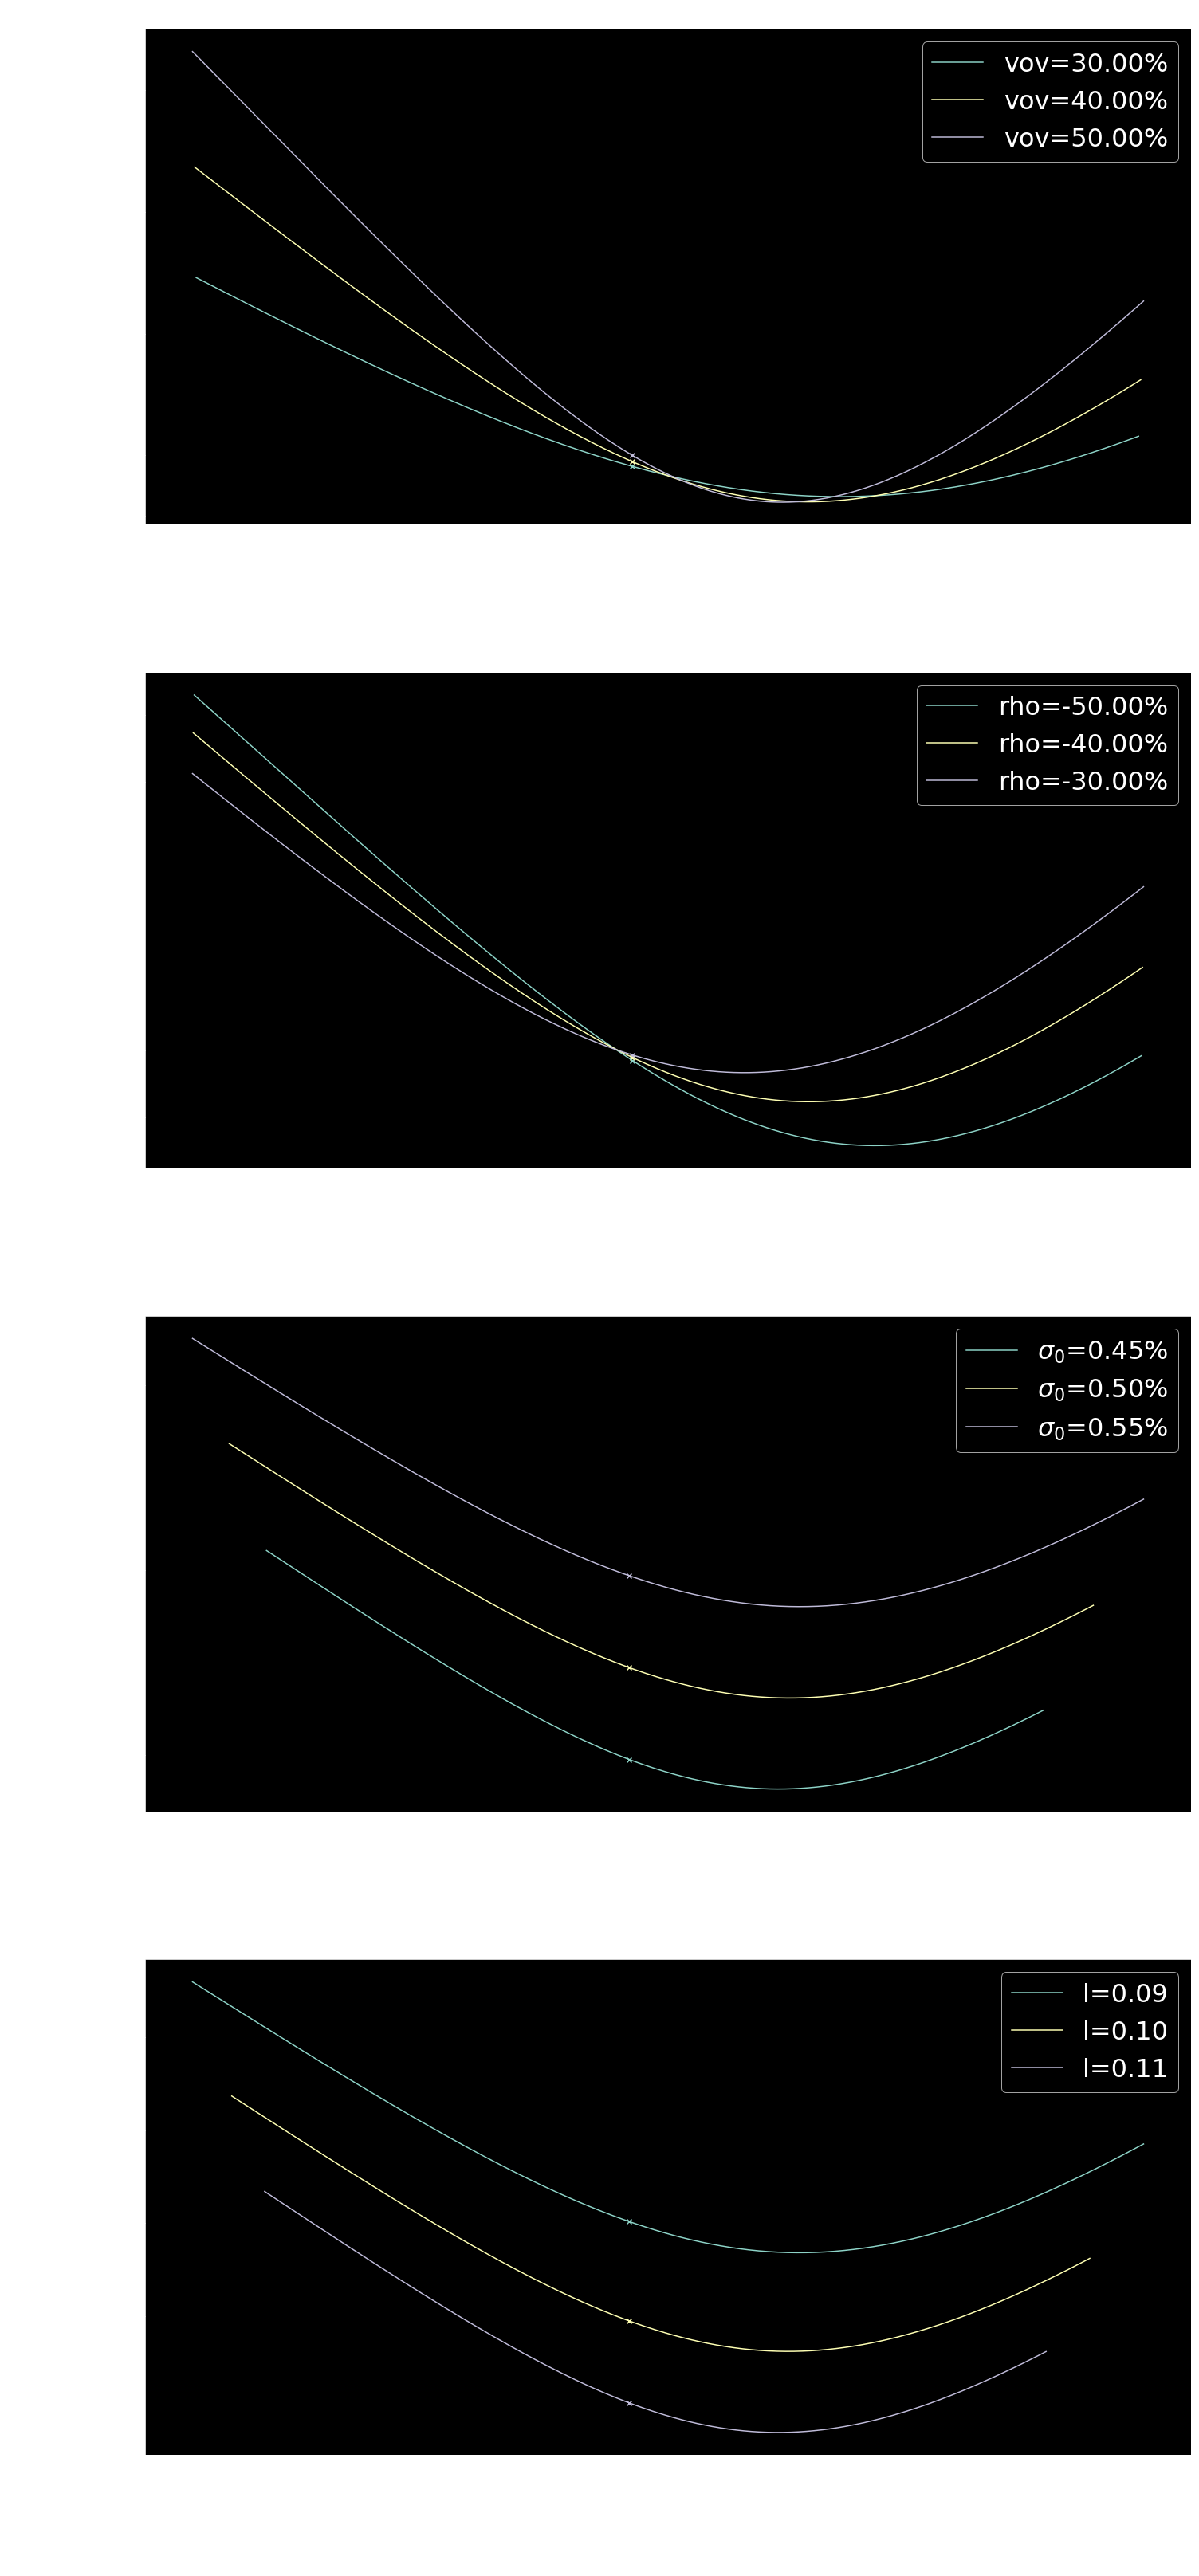

In [10]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 2*ONE_PCT

vov_shocks = [-0.1, 0, 0.1]
rho_shocks = [-0.1, 0, 0.1]
sigma_0_shocks = [-5*ONE_BP, 0, 5*ONE_BP]
l_shocks = [0.9, 1, 1.1]

vov = 40*ONE_PCT
rho = -40*ONE_PCT
sigma_0 = 50*ONE_BP
l = 0.1

fig, axes = plt.subplots(figsize=(21, 45), nrows=4, ncols=1)

ax = axes[0]  
model = SABR_tanh_N(l=l, vov=vov, rho=rho, f=f, sigma_0=sigma_0,\
                    n_strikes=N_STRIKES, T_expiry=1,\
                    moneyness_lo=-3, moneyness_hi=3)

for vov_shock in vov_shocks:
    model.vov = vov+vov_shock
    
    smile = model.smile.values()
    label = 'vov={:.2%}'.format(vov+vov_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
    ax.legend(loc='upper right', prop={'size': LEGEND_SIZE})
    ax.tick_params(labelsize=FONT_SIZE)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title('Vol of vol shock', fontsize=FONT_SIZE)

ax = axes[1]
model = SABR_tanh_N(l=l, vov=vov, rho=rho, f=f, sigma_0=sigma_0,\
                    n_strikes=N_STRIKES, T_expiry=1,\
                    moneyness_lo=-3, moneyness_hi=3)

for rho_shock in rho_shocks:
    model.rho = rho+rho_shock
    
    smile = model.smile.values()
    label = 'rho={:.2%}'.format(rho+rho_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
    ax.legend(loc='upper right', prop={'size': LEGEND_SIZE})
    ax.tick_params(labelsize=FONT_SIZE)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title('Correlation shock', fontsize=FONT_SIZE)
    
ax = axes[2]
model = SABR_tanh_N(l=l, vov=vov, rho=rho, f=f, sigma_0=sigma_0,\
                    n_strikes=N_STRIKES, T_expiry=1,\
                    moneyness_lo=-3, moneyness_hi=3)

for sigma_0_shock in sigma_0_shocks:
    model.sigma_0 = sigma_0+sigma_0_shock

    smile = model.smile.values()
    label = r'$\sigma_0$={:.2%}'.format(sigma_0+sigma_0_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
    ax.legend(loc='upper right', prop={'size': LEGEND_SIZE})
    ax.tick_params(labelsize=FONT_SIZE)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title('Initial vol shock', fontsize=FONT_SIZE)

ax = axes[3]
model = SABR_tanh_N(l=l, vov=vov, rho=rho, f=f, sigma_0=sigma_0,\
                    n_strikes=N_STRIKES, T_expiry=1,\
                    moneyness_lo=-3, moneyness_hi=3)

for l_shock in l_shocks:
    model.l = l*l_shock
    smile = model.smile.values()
    label = r'l={:.2f}'.format(model.l)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
    ax.legend(loc='upper right', prop={'size': LEGEND_SIZE})
    ax.tick_params(labelsize=FONT_SIZE)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title(r'l shock', fontsize=FONT_SIZE)
    
plt.tight_layout()
plt.show()